In [23]:
%pip install duckdb pandas numpy pyspainmobility requests seaborn

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


<h1 align="center"><b>Building a 3-Tier Data Lakehouse for Mobility Analysis in Spain</b></h1>
<h3 align="center"><b style="color:gray">Gold Layer</b></h3>
<h4 align="right">Joan Fernández Navarro & Borja Albert Gramaje</h4>
<h3><b>Table of Contents</b></h3>
<ul style = "list-style-type: none; line-height: 0.5em;">
    <li><a href="#q1"><h5>1. Business Question 1</h5></a></li>
    <li><a href="#q2"><h5>2. Business Question 2</h5></a></li>
</ul>

In [1]:
import os
import duckdb
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspainmobility import Mobility, Zones

plt.style.use('seaborn-v0_8')
LAKE_LAYER = "gold"

con = duckdb.connect("./../../mobility.db")

def SQL(q):
    """Run SQL (printed for clarity) and return a DataFrame."""
    return con.execute(q).fetchdf()

print("DuckDB version:", con.sql("SELECT version();").fetchone()[0])

DuckDB version: v1.4.2


<h2 id="q1"><b>1. Business Question 1: Typical Day in Mobility for a Reference Year</b></h2>

In [2]:
SQL("""
    CREATE OR REPLACE TABLE gold_typical_day_patterns AS
    WITH daily_aggregates AS (
        SELECT
            zone_level,
            fecha,
            hora,
            is_weekend,
            is_holiday,
            SUM(viajes) AS total_viajes
        FROM silver_od_all
        GROUP BY zone_level, fecha, hora, is_weekend, is_holiday
    ),
    day_types AS (
        SELECT
            zone_level,
            hora,
            CASE
                WHEN is_holiday THEN 'festivo'
                WHEN is_weekend THEN 'fin_semana'
                ELSE 'laborable'
            END AS tipo_dia,
            AVG(total_viajes) AS avg_viajes_por_hora
        FROM daily_aggregates
        GROUP BY zone_level, hora, tipo_dia
    )
    SELECT * FROM day_types
    ORDER BY zone_level, hora, tipo_dia;
""")

,Count
0,72


In [3]:
SQL("""
WITH ranking_horas AS (
    SELECT
        hora,
        tipo_dia,
        zone_level,
        avg_viajes_por_hora,
        RANK() OVER (
            PARTITION BY tipo_dia, zone_level
            ORDER BY avg_viajes_por_hora DESC
        ) as ranking
    FROM gold_typical_day_patterns
)

SELECT * 
FROM ranking_horas
WHERE ranking <= 5
ORDER BY zone_level, tipo_dia, ranking;
""")

,hora,tipo_dia,zone_level,avg_viajes_por_hora,ranking
0,23,laborable,distritos,7.332878e+14,1
1,1,laborable,distritos,1.810581e+14,2
2,4,laborable,distritos,9.340540e+12,3
3,0,laborable,distritos,5.646365e+12,4
4,3,laborable,distritos,3.307336e+12,5
5,23,laborable,gau,1.815982e+14,1
6,1,laborable,gau,9.616397e+13,2
7,4,laborable,gau,9.513156e+12,3
8,0,laborable,gau,5.667453e+12,4
9,2,laborable,gau,3.212585e+12,5


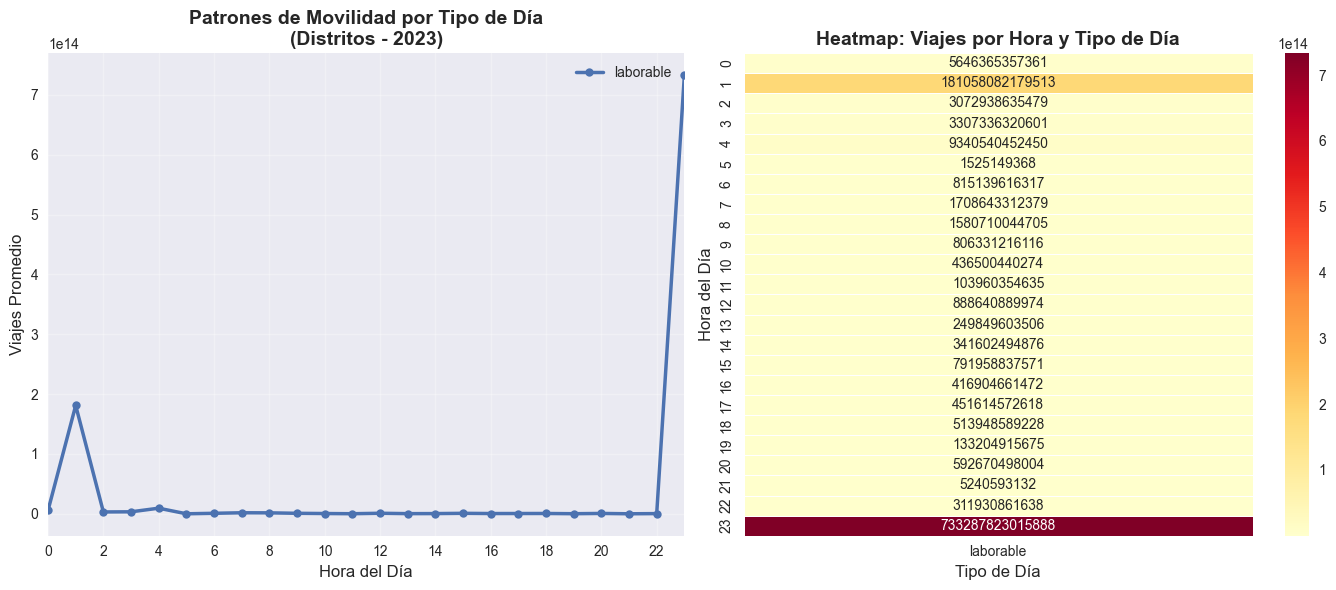

In [6]:
df_bq1 = SQL("""
    SELECT hora, tipo_dia, avg_viajes_por_hora 
    FROM gold_typical_day_patterns 
    WHERE zone_level = 'distritos'
    ORDER BY hora, tipo_dia
""")

# Crear figura con 2 subplots verticales
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Gráfico de líneas
for tipo_dia in df_bq1['tipo_dia'].unique():
    data = df_bq1[df_bq1['tipo_dia'] == tipo_dia]
    axs[0].plot(data['hora'], data['avg_viajes_por_hora'], 
                marker='o', label=tipo_dia, linewidth=2.5, markersize=6)

axs[0].set_xlabel('Hora del Día', fontsize=12)
axs[0].set_ylabel('Viajes Promedio', fontsize=12)
axs[0].set_title('Patrones de Movilidad por Tipo de Día\n(Distritos - 2023)', fontsize=14, fontweight='bold')
axs[0].legend(fontsize=10)
axs[0].grid(True, alpha=0.3)
axs[0].set_xticks(range(0, 24, 2))
axs[0].set_xlim(0, 23)

# Subplot 2: Heatmap de diferencias horarias
heatmap_data = df_bq1.pivot(index='hora', columns='tipo_dia', values='avg_viajes_por_hora')
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='.0f', linewidths=0.5, ax=axs[1])
axs[1].set_title('Heatmap: Viajes por Hora y Tipo de Día', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Tipo de Día', fontsize=12)
axs[1].set_ylabel('Hora del Día', fontsize=12)

plt.tight_layout()
plt.show()

<h2 id="q1"><b>1. Business Question 2: Where is Transport Infrastructure Most Lacking?</b></h2>

In [25]:
SQL("""
-- Crear tabla gold para el modelo de gravedad
CREATE OR REPLACE TABLE gold_infrastructure_gaps AS
WITH zone_attributes AS (
    SELECT 
        id AS zone_id,
        zone_level,
        population,
        centroid_latitude,
        centroid_longitude
    FROM silver_zones_all
    WHERE zone_level = 'distritos'  -- Empezamos con distritos
),
distance_matrix AS (
    SELECT 
        a.zone_id AS origen_id,
        b.zone_id AS destino_id,
        a.population AS poblacion_origen,
        b.population AS poblacion_destino,
        -- Distancia Euclidiana entre centroides (km aproximados)
        SQRT(POW(a.centroid_latitude - b.centroid_latitude, 2) + 
             POW(a.centroid_longitude - b.centroid_longitude, 2)) * 111 AS distancia_km
    FROM zone_attributes a
    CROSS JOIN zone_attributes b
    WHERE a.zone_id != b.zone_id
),
gravity_model AS (
    SELECT 
        dm.origen_id,
        dm.destino_id,
        dm.distancia_km,
        -- Modelo de gravedad básico: T_ij = k * (P_i * P_j) / d_ij^2
        (dm.poblacion_origen * dm.poblacion_destino) / NULLIF(POW(dm.distancia_km, 2), 0) AS viajes_estimados_gravity
    FROM distance_matrix dm
),
actual_viajes AS (
    SELECT 
        origen_zone_id,
        destino_zone_id,
        AVG(viajes) AS viajes_reales_promedio
    FROM silver_od_all 
    WHERE zone_level = 'distritos' 
      AND EXTRACT(YEAR FROM fecha) = 2023
      AND is_weekend = FALSE 
      AND is_holiday = FALSE
      AND hora BETWEEN 7 AND 9  -- Hora pico mañana
    GROUP BY origen_zone_id, destino_zone_id
),
comparison AS (
    SELECT 
        g.origen_id,
        g.destino_id,
        g.distancia_km,
        g.viajes_estimados_gravity,
        COALESCE(a.viajes_reales_promedio, 0) AS viajes_reales,
        -- Ratio de discrepancia
        CASE 
            WHEN COALESCE(a.viajes_reales_promedio, 0) = 0 THEN g.viajes_estimados_gravity
            ELSE g.viajes_estimados_gravity / NULLIF(a.viajes_reales_promedio, 0)
        END AS ratio_discrepancia,
        -- Gap absoluto
        g.viajes_estimados_gravity - COALESCE(a.viajes_reales_promedio, 0) AS gap_absoluto
    FROM gravity_model g
    LEFT JOIN actual_viajes a ON g.origen_id = a.origen_zone_id AND g.destino_id = a.destino_zone_id
),
zone_gaps AS (
    SELECT 
        origen_id AS zone_id,
        AVG(ratio_discrepancia) AS avg_ratio_discrepancia,
        SUM(gap_absoluto) AS total_gap_absoluto,
        COUNT(*) AS num_pares_od
    FROM comparison
    WHERE distancia_km BETWEEN 5 AND 50  -- Distancias relevantes para transporte
    GROUP BY origen_id
)
SELECT 
    zg.*,
    za.population,
    za.zone_level,
    -- Score de infraestructura (mayor score = mayor necesidad)
    zg.avg_ratio_discrepancia * LOG(zg.total_gap_absoluto + 1) AS infrastructure_gap_score
FROM zone_gaps zg
JOIN zone_attributes za ON zg.zone_id = za.zone_id
ORDER BY infrastructure_gap_score DESC;
""")

,Count
0,1547


In [8]:
SQL("""
    SELECT 
        zone_id,
        ROUND(population, 0) as poblacion,
        ROUND(avg_ratio_discrepancia, 2) as ratio_discrepancia,
        ROUND(infrastructure_gap_score, 2) as gap_score
    FROM gold_infrastructure_gaps 
    ORDER BY infrastructure_gap_score DESC 
    LIMIT 10
""")

,zone_id,poblacion,ratio_discrepancia,gap_score
0,2807913,2385770.0,1.353132e+10,1.626929e+11
1,2807911,2580640.0,1.323534e+10,1.590071e+11
2,2807915,2164000.0,1.114493e+10,1.329988e+11
3,2807910,2396930.0,9.634885e+09,1.145293e+11
4,2807917,1544640.0,8.789786e+09,1.040852e+11
5,2807916,1928090.0,8.450920e+09,9.983406e+10
6,2807901,1406440.0,8.357079e+09,9.868495e+10
7,2807920,1599000.0,7.943791e+09,9.380436e+10
8,2807906,1595640.0,7.716396e+09,9.089536e+10
9,2807905,1454440.0,7.665139e+09,9.026938e+10


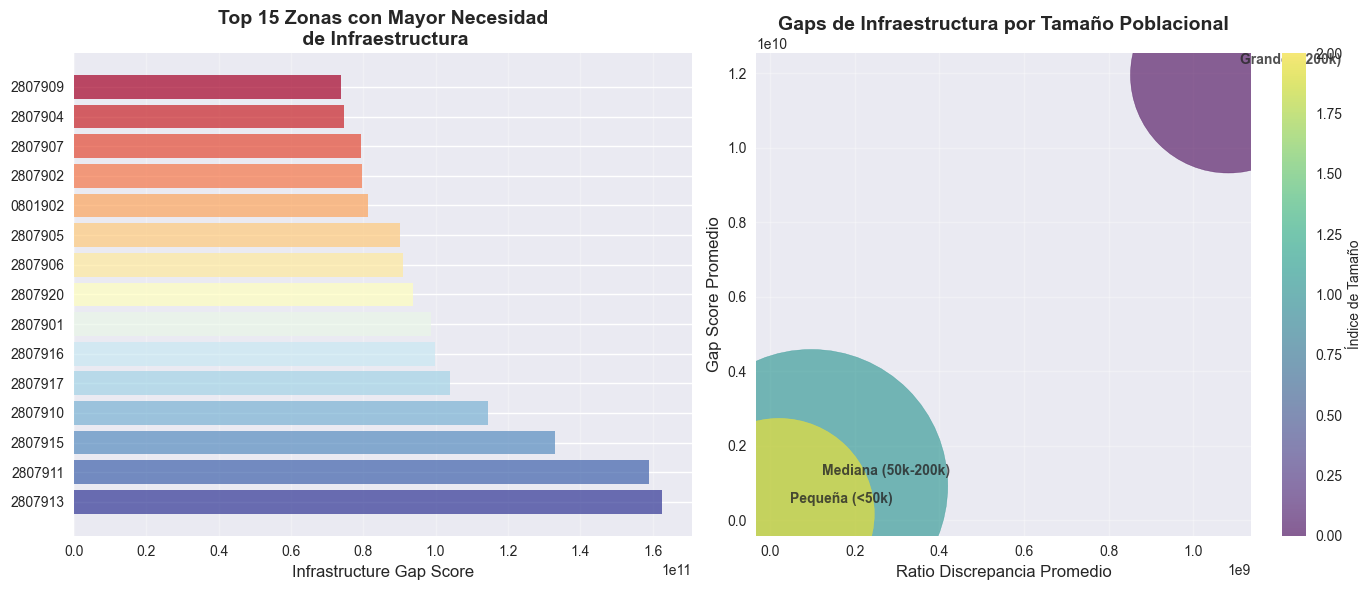

In [7]:
df_bq2_top = SQL("""
    SELECT 
        zone_id,
        population,
        avg_ratio_discrepancia,
        infrastructure_gap_score
    FROM gold_infrastructure_gaps 
    ORDER BY infrastructure_gap_score DESC 
    LIMIT 15
""")

df_bq2_dist = SQL("""
    SELECT 
        CASE 
            WHEN population < 50000 THEN 'Pequeña (<50k)'
            WHEN population BETWEEN 50000 AND 200000 THEN 'Mediana (50k-200k)'
            ELSE 'Grande (>200k)'
        END AS tamaño_poblacion,
        AVG(avg_ratio_discrepancia) AS avg_ratio,
        AVG(infrastructure_gap_score) AS avg_gap_score,
        COUNT(*) AS num_zonas
    FROM gold_infrastructure_gaps
    GROUP BY tamaño_poblacion
    ORDER BY avg_gap_score DESC
""")

# Crear figura para BQ2 con 2 subplots horizontales
fig2, axs2 = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Top zonas con mayor gap
colors = plt.cm.RdYlBu_r(np.linspace(0, 1, len(df_bq2_top)))
bars = axs2[0].barh(df_bq2_top['zone_id'].astype(str), 
                   df_bq2_top['infrastructure_gap_score'], 
                   color=colors, alpha=0.7)
axs2[0].set_xlabel('Infrastructure Gap Score', fontsize=12)
axs2[0].set_title('Top 15 Zonas con Mayor Necesidad\n de Infraestructura', fontsize=14, fontweight='bold')
axs2[0].grid(True, alpha=0.3, axis='x')

# Subplot 2: Gap por tamaño poblacional
sizes = df_bq2_dist['num_zonas'] * 50  # Escalar para mejor visualización
scatter = axs2[1].scatter(df_bq2_dist['avg_ratio'], 
                         df_bq2_dist['avg_gap_score'], 
                         s=sizes, alpha=0.6, 
                         c=range(len(df_bq2_dist)), cmap='viridis')

# Añadir etiquetas
for i, row in df_bq2_dist.iterrows():
    axs2[1].annotate(row['tamaño_poblacion'], 
                    (row['avg_ratio'], row['avg_gap_score']),
                    xytext=(8, 8), textcoords='offset points',
                    fontsize=10, alpha=0.8, fontweight='bold')

axs2[1].set_xlabel('Ratio Discrepancia Promedio', fontsize=12)
axs2[1].set_ylabel('Gap Score Promedio', fontsize=12)
axs2[1].set_title('Gaps de Infraestructura por Tamaño Poblacional', fontsize=14, fontweight='bold')
axs2[1].grid(True, alpha=0.3)

# Añadir colorbar para el scatter plot
cbar = plt.colorbar(scatter, ax=axs2[1])
cbar.set_label('Índice de Tamaño', fontsize=10)

plt.tight_layout()
plt.show()